# <center>Assignment #3. Task </center> <a class="tocSkip">
## <center>Decision trees for classification and regression </center><a class="tocSkip">

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

# if seaborn is not yet installed, run `pip install seaborn` in terminal
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

sns.set()
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'

## 1. Decision trees for regression: a toy example

Let's consider the following one-dimensional regression problem. We need to build a function $\large a(x)$ to approximate the dependency $\large y = f(x)$ using the mean-squared error criterion: $\large \min \sum_i {(a(x_i) - f(x_i))}^2$.

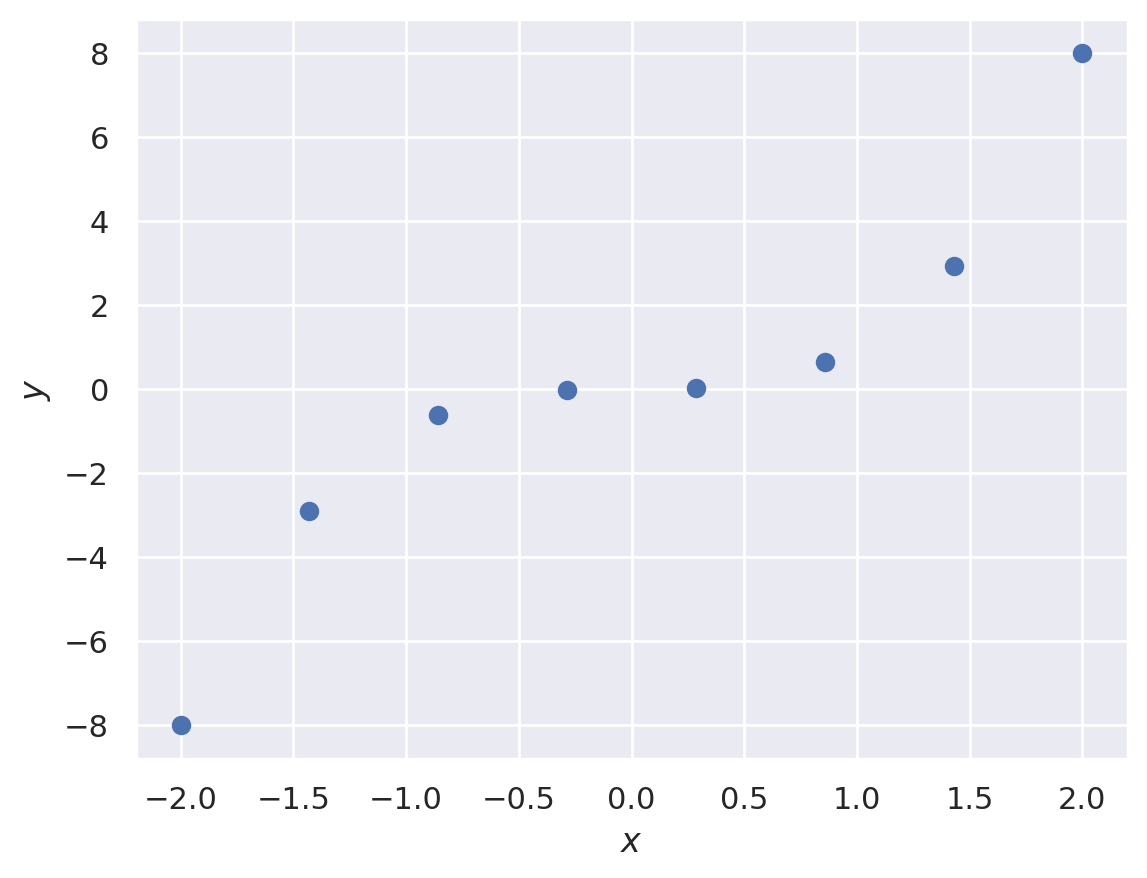

In [3]:
X = np.linspace(-2, 2, 8)
y = X ** 3  # original dependecy

plt.scatter(X, y)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$");

Let's make several steps to build a decision tree. In the case of a **regression** task, at prediction time, the leaf returns the average value for all observations in this leaf.

Let's start with a tree of depth 0, i.e. all observations placed in a single leaf. 

<br>You'll need to build a tree with only one node (also called **root**) that contains all train observations (instances). 
<br>How will predictions of this tree look like for $x \in [-2, 2]$? <br> Create an appropriate plot using a pen, paper and Python if needed (but no `sklearn` is needed yet).

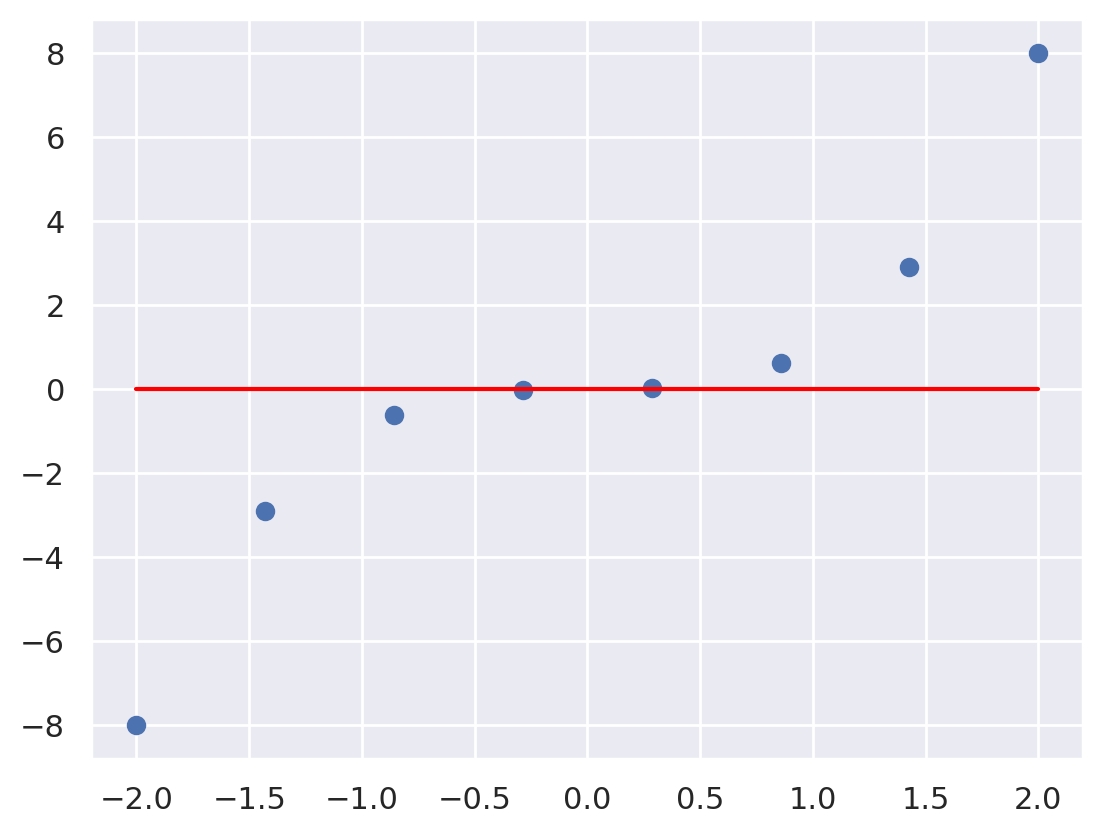

In [4]:
# You code here 

# we create a new sample
x = np.linspace(-2, 2, 100)
# as we have only the route, there is always mean among all observations
predictions = [np.mean(y) for t in x]

plt.scatter(X, y)
plt.plot(x, predictions, c="red");

**Making first splits.**
<br>Let's split the data according to the following condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. To clarify, for all instances with $x \geqslant 0$ the tree will return some value, for all instances with $x < 0$ it will return another value. Let's create a similar plot for predictions of this tree.

In [5]:
X

array([-2.        , -1.42857143, -0.85714286, -0.28571429,  0.28571429,
        0.85714286,  1.42857143,  2.        ])

In [6]:
y

array([-8.        , -2.9154519 , -0.62973761, -0.02332362,  0.02332362,
        0.62973761,  2.9154519 ,  8.        ])

In [7]:
y[X<0]

array([-8.        , -2.9154519 , -0.62973761, -0.02332362])

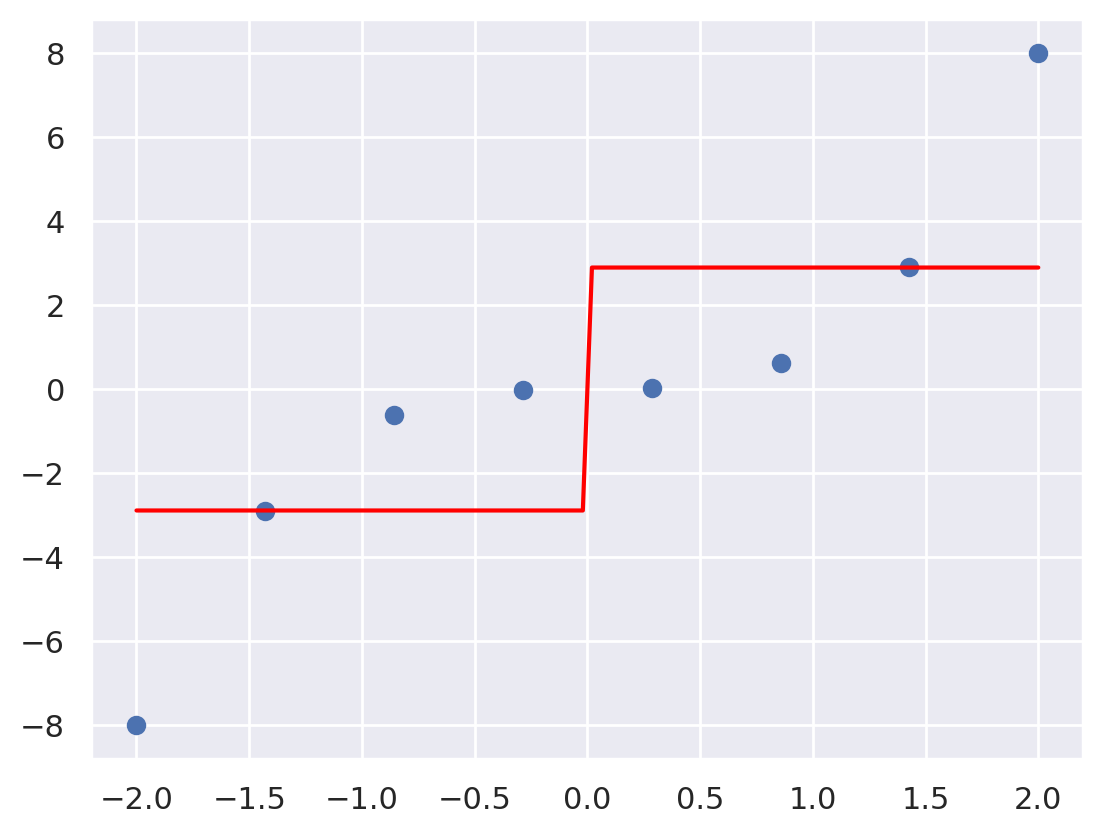

In [8]:
# You code here 
predictions = [np.mean(y[X<0]) if i < 0 else np.mean(y[X>=0]) for i in x]

plt.scatter(X, y)
plt.plot(x, predictions, c="red");

In the decision tree algorithm, the feature and the threshold for splitting are chosen according to some criterion. The commonly used criterion for regression is based on variance:

$$\large Q(X, y, j, t) = D(X, y) - \dfrac{|X_l|}{|X|} D(X_l, y_l) - \dfrac{|X_r|}{|X|} D(X_r, y_r),$$

where $\large X$ and $\large y$ are a feature matrix and a target vector (correspondingly) for training instances in a current node, $\large X_l, y_l$ and $\large X_r, y_r$ are splits of samples $\large X, y$ into two parts w.r.t. $\large [x_j < t]$ (by $\large j$-th feature and threshold $\large t$), $\large |X|$, $\large |X_l|$, $\large |X_r|$ (or, the same, $\large |y|$, $\large |y_l|$, $\large |y_r|$) are sizes of appropriate samples, and $\large D(X, y)$ is variance of answers $\large y$ for all instances in $\large X$:

$$\large D(X, y) = \dfrac{1}{|X|} \sum_{j=1}^{|X|}(y_j – \dfrac{1}{|X|}\sum_{i = 1}^{|X|}y_i)^2$$

Here $\large y_i = y(x_i)$ is the answer for the $\large x_i$ instance. Feature index $\large j$ and threshold $\large t$ are chosen to maximize the value of criterion  $\large Q(X, y, j, t)$ for each split.

In our 1D case,  there's only one feature so $\large Q$ depends only on threshold $\large t$ and training data $\large X$ and $\large y$. Let's designate it $\large Q_{1d}(X, y, t)$ meaning that the criterion no longer depends on feature index $\large j$, i.e. in 1D case $\large j = 1$.

**Explanation not given by the authors of the tasks:**

> In the regression task we assume that the loss function equals to sqared deviation, then the information criterion will be the following:
$$\large H(R) = min\dfrac{1}{|R|}\sum_{(x_i, y_i \in R)}(y_i - с)^2$$

> Mininum of the above equation will be reached at the average value of the target variable, hence, the information criterion might be re-written in the following way:
$$\large H(R) =  \dfrac{1}{|R|}\sum_{(x_i, y_i \in R)}(y_i - \dfrac{1}{|R|}\sum_{(x_i, y_i \in R)}y_i)^2$$

> Hence, we derived that the informativity of the node is measured by its dispersion: the lower the dispersion of the target variable, the better the node is.

In [9]:
# You code here
def regression_var_criterion(X, y, t):
    j = 1

    left_split_y = y[X<t]
    right_split_y = y[X>=t]

    left_split_x = X[X<t]
    right_split_x = X[X>=t]

    return np.var(y) - left_split_x.shape[0]/X.shape[0] * np.var(left_split_y) -  right_split_x.shape[0]/X.shape[0] * np.var(right_split_y)

Create the plot of criterion $\large Q_{1d}(X, y, t)$  as a function of threshold value $t$ on the interval $\large [-1.9, 1.9]$.

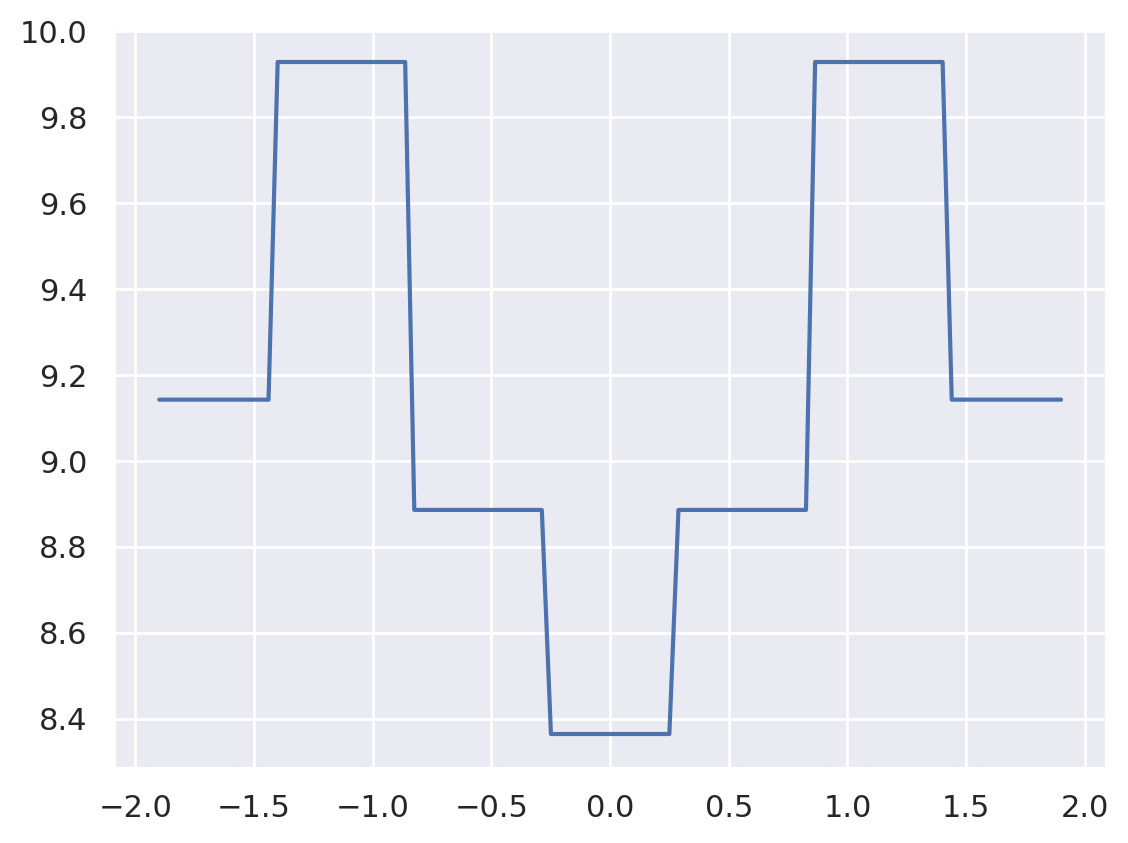

In [10]:
# You code here
t = np.linspace(-1.9, 1.9, 100)
q_values = [regression_var_criterion(X,y,i) for i  in t]

plt.plot(t, q_values )

**<font color='red'>Question 1.</font> What is the worst threshold value (to perform a split) according to the variance criterion?**
- -1.9
- -1.3
- 0
- 1.3
- 1.9 

Then let's make splitting in each of the leaves nodes. 
<br> Take your tree with first threshold [$x<0$].
<br> Now add a split in the left branch (where previous split was $x < 0$) using the criterion $[x < -1.5]$, in the right branch (where previous split was $x \geqslant 0$) with the following criterion $[x < 1.5]$. 
<br>It gives us a tree of depth 2 with 7 nodes and 4 leaves. Create a plot of this tree predictions for $x \in [-2, 2]$.

In [11]:
X = np.linspace(-2, 2, 8)
y = X ** 3  # original dependecy

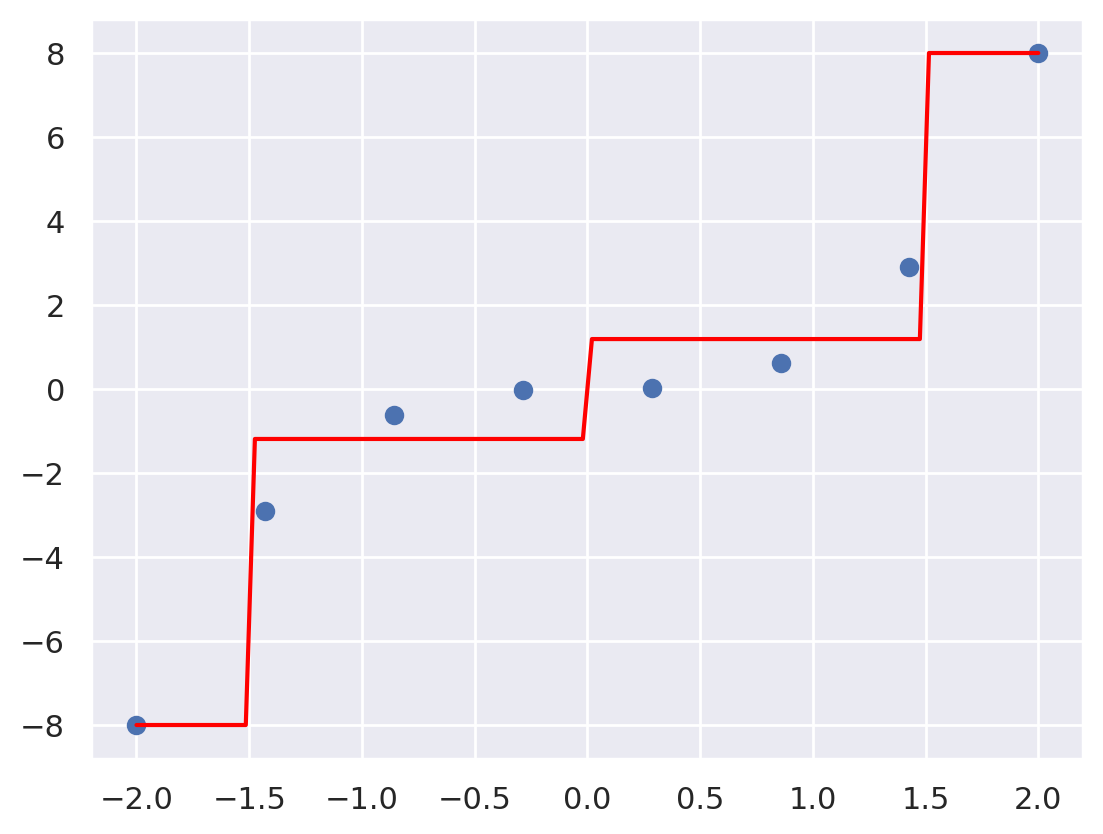

In [12]:
# You code here

def predict(X, y, t):
    if t >= 1.5:
        return np.mean(y[X >= 1.5])
    elif t < 1.5 and t >= 0:
        return np.mean(y[(X >= 0) & (X < 1.5)])
    elif t >= -1.5 and t < 0:
        return np.mean(y[(X < 0) & (X >= -1.5)])
    else:
        return np.mean(y[X < -1.5])

t = np.linspace(-2, 2, 100)
preds = [predict(X, y, i) for i  in t]

plt.scatter(X, y)
plt.plot(t, preds, c="red");

**<font color='red'>Question 2.</font> Tree predictions is a piecewise-constant function, right? How many "pieces" (horizontal segments in the plot that you've just built) are there in the interval [-2, 2]?**
- 2
- 4
- 6
- 8

## 2. Building a decision tree for predicting heart diseases
Let's read the data on heart diseases. The dataset can be downloaded from the course repo from [here](https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv) by clicking on `Download` and then selecting `Save As` option. If you work with Git, then the dataset is already there in `data/mlbootcamp5_train.csv`.

**Problem**

Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

**Data description**

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [93]:
df = pd.read_csv(
    "/content/drive/MyDrive/mlcourse_ai_bonus_jupyter_book/_static/data/assignment3/mlbootcamp5_train.csv", index_col="id", sep=";"
)

Transform the features: 
- create "age in years" dividing age by 365.25 and taking floor ($\lfloor{x}\rfloor$ is the largest integer that is less than or equal to $x$) 
- create 3 binary features based on `cholesterol`.
- create 3 binary features based on `gluc`.
<br> Binary features equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummies`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

In [105]:
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm
tqdm.pandas()

In [94]:
# You code here 
df['age'] = df['age'].progress_apply(lambda x: math.floor(x/365.25))

  0%|          | 0/70000 [00:00<?, ?it/s]

In [95]:
df = df.reset_index(drop=True)

In [96]:
ohe_cholesterol = OneHotEncoder(handle_unknown='ignore')
# calculating values for OHE for selected column
values_cholesterol = ohe_cholesterol.fit_transform(df['cholesterol'].values.reshape(-1, 1)).toarray()
# getting features names
columns_names_cholesterol = ohe_cholesterol.get_feature_names_out(['cholesterol']).tolist()
# converting to dataframe
df_1 = pd.DataFrame(values_cholesterol, columns = columns_names_cholesterol)

df_modified = pd.concat([df, df_1], axis = 1).drop(['cholesterol'], axis = 1)

In [98]:
ohe_gluc = OneHotEncoder(handle_unknown='ignore')
# calculating values for OHE for selected column
values_gluc = ohe_gluc.fit_transform(df['gluc'].values.reshape(-1, 1)).toarray()
# getting features names
columns_names_gluc = ohe_gluc.get_feature_names_out(['gluc']).tolist()
# converting to dataframe
df_2 = pd.DataFrame(values_gluc, columns = columns_names_gluc)

final_df = pd.concat([df_modified,df_2], axis = 1).drop(['gluc'], axis = 1)

Split data into train and holdout parts in the proportion of 7/3 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [99]:
# You code here 
X = final_df.drop(['cardio'], axis = 1).values
y = final_df['cardio'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33,
                                                      random_state=42)

Train a decision tree on the dataset `(X_train, y_train)` with **max depth equal to 3** and `random_state=17`. Plot this tree with `sklearn.tree.export_graphviz` and Graphviz. Here we need to mention that `sklearn` doesn't draw decision trees on its own, but is able to output a tree in the `.dot` format that can be used by Graphviz for visualization. 

How to plot a decision tree, alternatives:
 1. Install Graphviz and pydotplus yourself (see below)
 2. Use our docker image with all needed packages already installed
 3. Easy way: execute `print(dot_data.getvalue())` with `dot_data` defined below (this can be done without pydotplus and Graphviz), go to http://www.webgraphviz.com, paste the graph code string (digraph Tree {...) and generate a nice picture

Take a look how trees are visualized in the [3rd part](https://mlcourse.ai/articles/topic3-dt-knn/) of course materials.

There are may be some troubles with graphviz for Windows users.
The error is 'GraphViz's executables not found'.
<br>To fix that – install Graphviz from [here](https://graphviz.gitlab.io/_pages/Download/Download_windows.html).
<br>Then add graphviz path to your system PATH variable. You can do this manually, but don't forget to restart kernel.
<br>Or just run this code:

In [ ]:
!apt install -y graphviz
!pip install graphviz

In [ ]:
# import os
# path_to_graphviz = '' # your path to graphviz (C:\\Program Files (x86)\\Graphviz2.38\\bin\\ for example)
# os.environ["PATH"] += os.pathsep + path_to_graphviz

> Detailed explanation of all parameters and logic [here](https://datagy.io/sklearn-decision-tree-classifier/)


In [100]:
# You code here 
clf = DecisionTreeClassifier(random_state=17, max_depth = 3)
model = clf.fit(X_train, y_train)

In [103]:
features_names = final_df.drop(['cardio'], axis = 1).columns.tolist()
labels = ['0', '1']

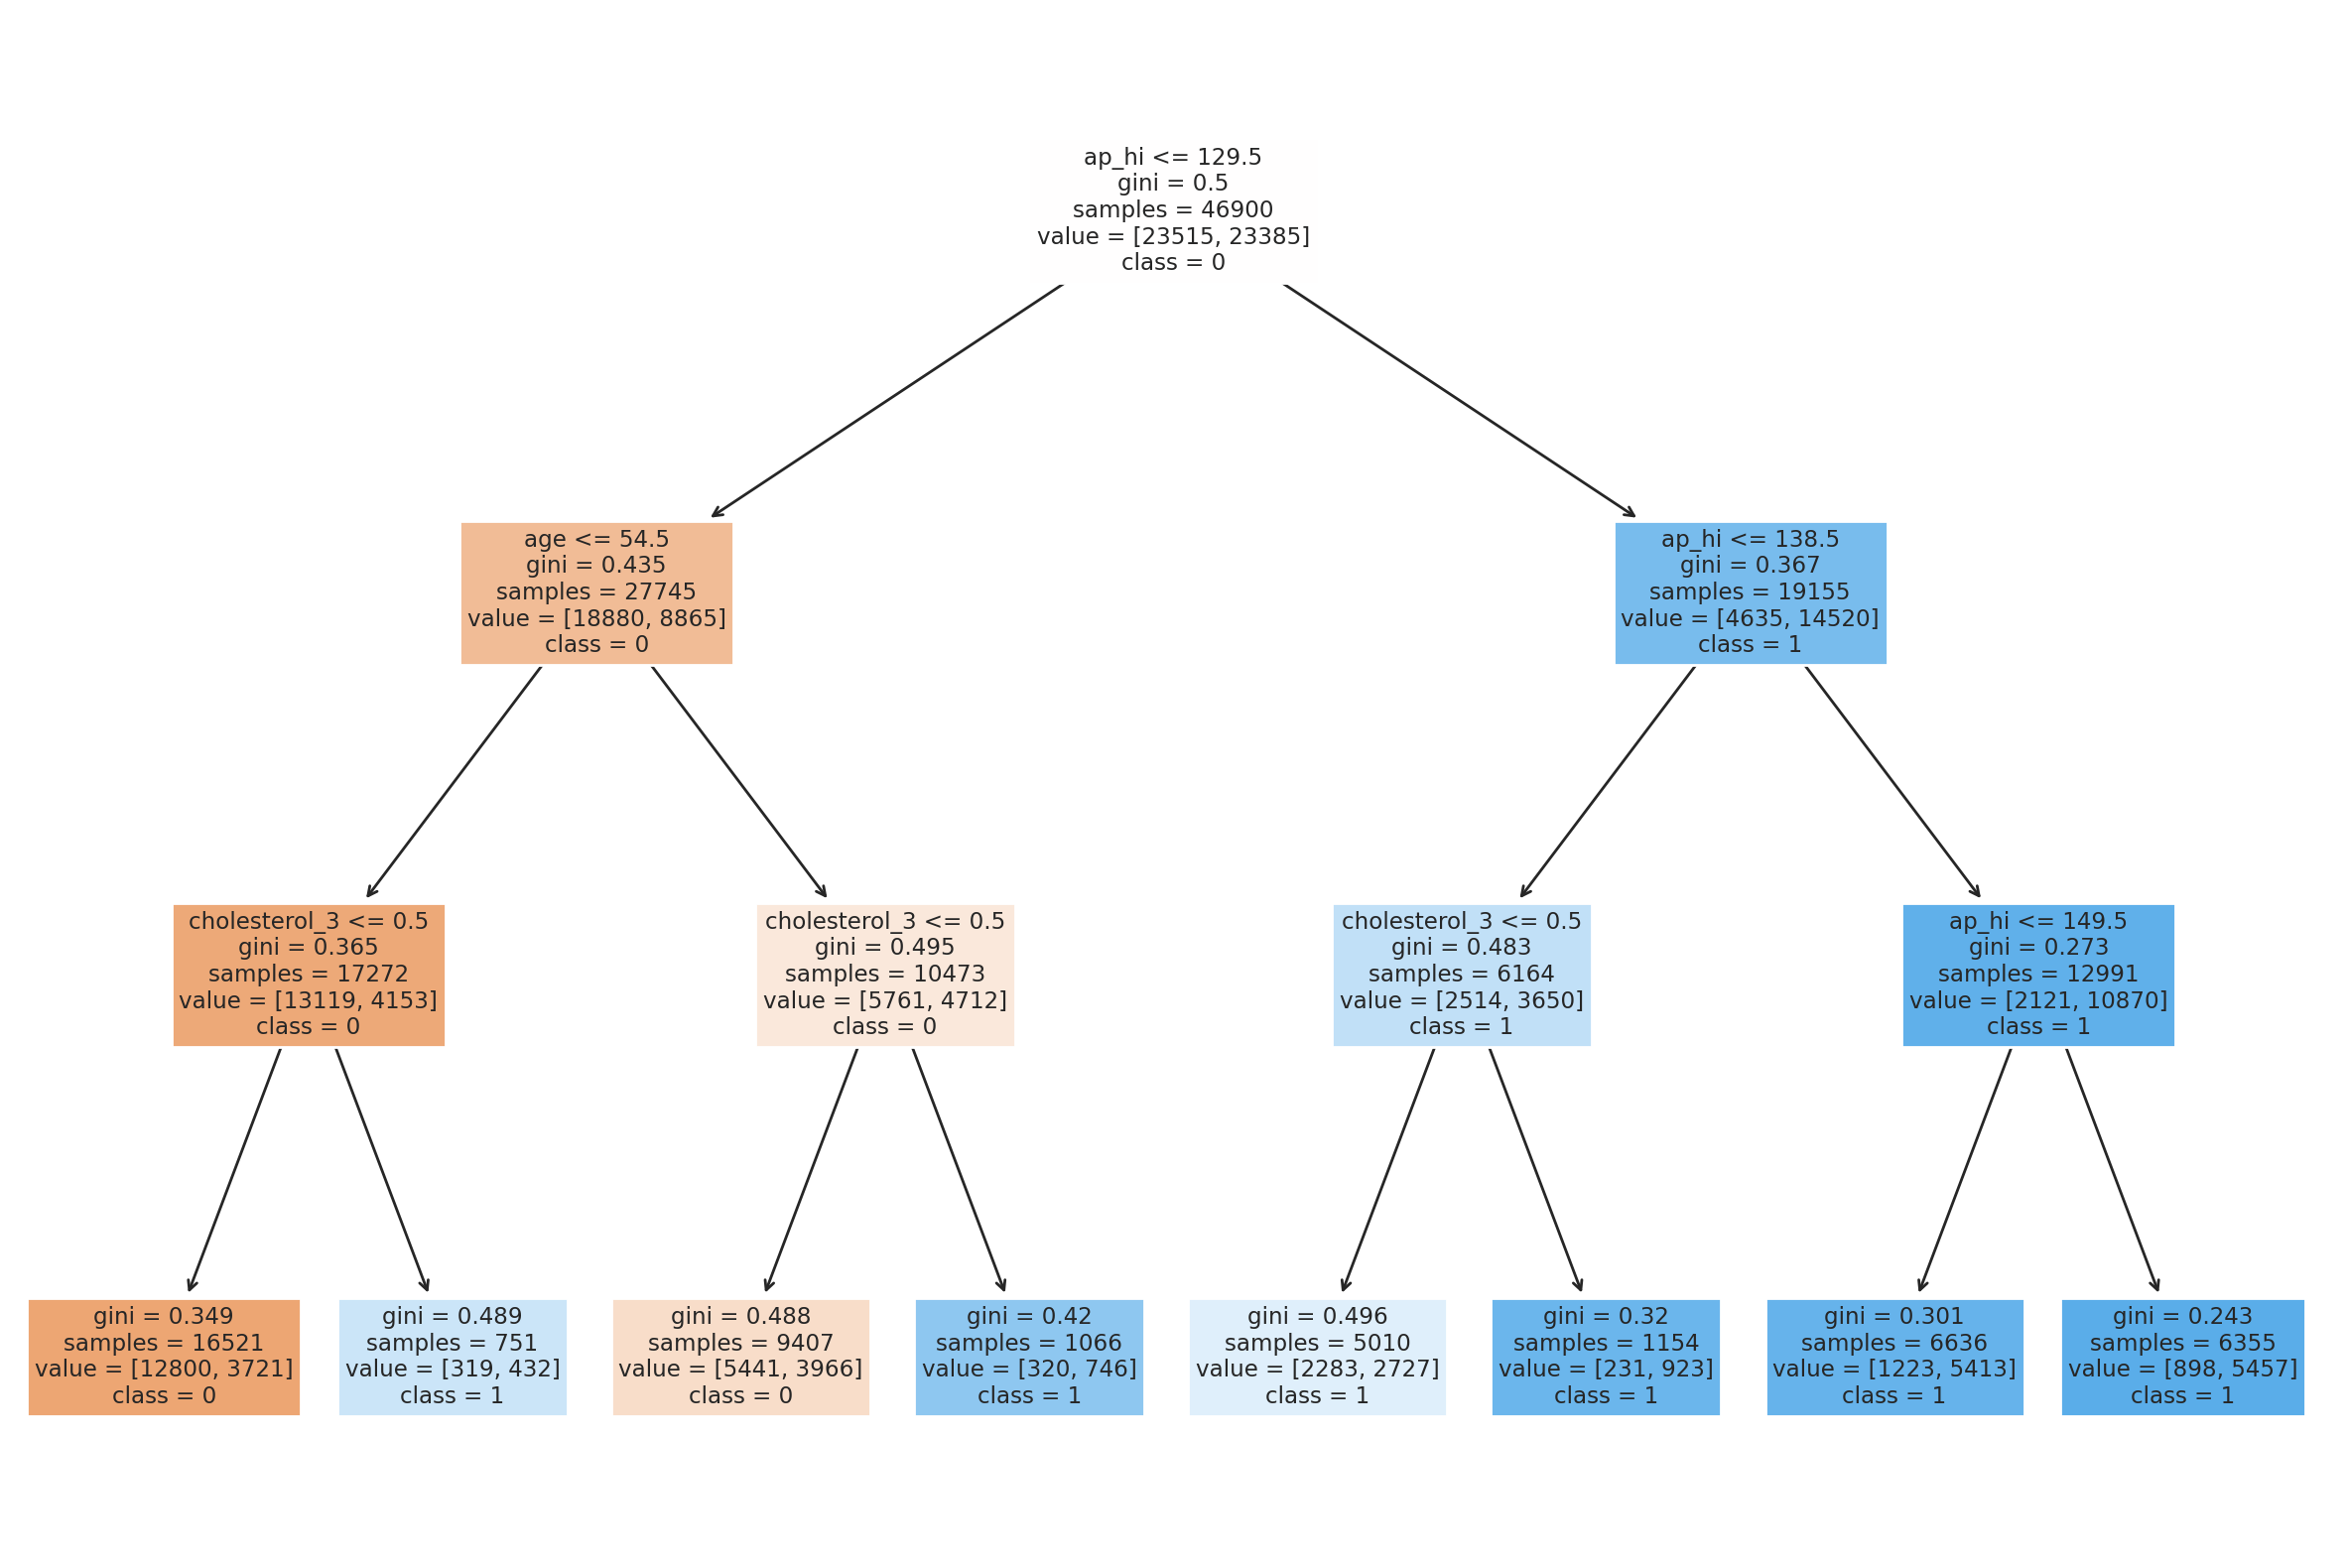

In [163]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf, 
                   feature_names=features_names,  
                   class_names=labels,
                   filled=True)

**<font color='red'>Question 3.</font> Which 3 features are used to make predictions in the created decision tree?**
- age, ap_lo, chol=1
- age, ap_hi, chol=3  **<font color='red'>[+]</font>**
- smoke, age, gender
- alco, weight, gluc=3

Make predictions for holdout data `(X_valid, y_valid)` with the trained decision tree. Calculate accuracy.

In [108]:
# You code here 
outputs = model.predict(X_valid)
accuracy = accuracy_score(outputs.tolist(), y_valid)
print(f'Accuracy for max_depth = 3: {round(accuracy, 2)}')

Accuracy for max_depth = 3: 0.73


Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

In [109]:
from sklearn.model_selection import GridSearchCV

In [125]:
# You code here
parametrs = {'max_depth': range (2, 11, 1)}
clf_cv = DecisionTreeClassifier(random_state=17,)

grid = GridSearchCV(clf_cv, parametrs, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)}, scoring='accuracy')

In [126]:
grid.__dict__

{'scoring': 'accuracy',
 'estimator': DecisionTreeClassifier(random_state=17),
 'n_jobs': None,
 'refit': True,
 'cv': 5,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'max_depth': range(2, 11)},
 'multimetric_': False,
 'best_index_': 3,
 'best_score_': 0.7291471215351812,
 'best_params_': {'max_depth': 5},
 'best_estimator_': DecisionTreeClassifier(max_depth=5, random_state=17),
 'refit_time_': 0.06115436553955078,
 'scorer_': make_scorer(accuracy_score),
 'cv_results_': {'mean_fit_time': array([0.02565503, 0.03795586, 0.04649386, 0.05491843, 0.06004057,
         0.06648517, 0.07302318, 0.08367791, 0.09177523]),
  'std_fit_time': array([0.00061363, 0.00343887, 0.00203498, 0.00410075, 0.00335119,
         0.00263978, 0.00199798, 0.00453353, 0.00373882]),
  'mean_score_time': array([0.00237737, 0.00254631, 0.00275326, 0.00266275, 0.00255685,
         0.00261259, 0.00281467, 0.0027534 , 0.00331168]),
  'std_score_time': ar

Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

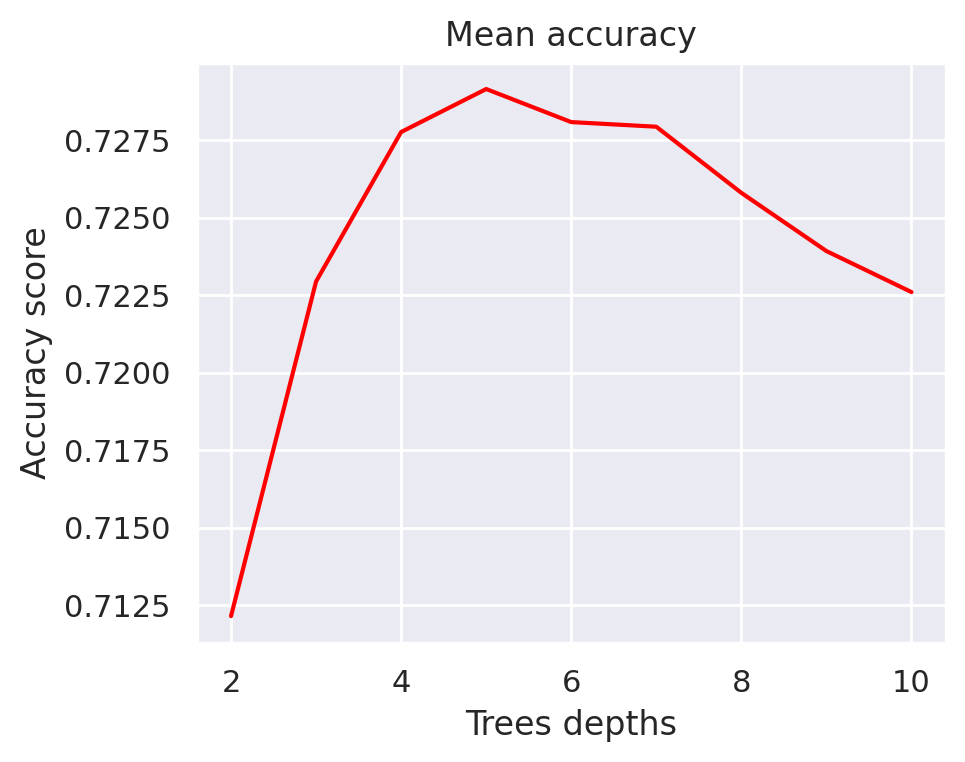

In [129]:
# You code here 
plt.subplots(1, figsize=(5,4))
plt.plot(grid.__dict__['cv_results_']['param_max_depth'],
          grid.__dict__['cv_results_']['mean_test_score'],
          label="Mean accuracy", color="red")

plt.title("Mean accuracy")
plt.xlabel("Trees depths")
plt.ylabel("Accuracy score")
plt.tight_layout()

Print the best value of `max_depth` where the mean value of cross-validation quality metric reaches maximum. Also compute accuracy on holdout data. This can be done with the trained instance of the class `GridSearchCV`.

In [137]:
# You code here 
best_max_depth = grid.best_params_['max_depth']
best_score = grid.best_score_
print(f'Best max_depth value: {best_max_depth}')
print(f'Best cross validaton score : {round(best_score, 2)}')

Best max_depth value: 5
Best cross validaton score : 0.73


Сalculate the effect of `GridSearchCV`: check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning max_depth with GridSearchCV respectively.

In [141]:
tuned_accuracy = accuracy_score(y_valid, grid.predict(X_valid))

In [143]:
# You code here 
difference = (tuned_accuracy-accuracy)/accuracy * 100
print(f'Effect of GridSearchCV: {difference}')
print('Tuned accuracy after GridSearchCV: ', tuned_accuracy)
print('Initial accuracy for max_depth = 3: ', accuracy)

Effect of GridSearchCV: 0.5395470176686784
Tuned accuracy after GridSearchCV:  0.7340692640692641
Initial accuracy for max_depth = 3:  0.7301298701298702


**<font color='red'>Question 4.</font> Choose all correct statements:**
- There exists a local maximum of accuracy on the built validation curve **<font color='red'>[+]</font>**
- `GridSearchCV` increased holdout accuracy by **more** than 1% 
- There is **no** local maximum of accuracy on the built validation curve
- `GridSearchCV` increased holdout accuracy by **less** than 1% **<font color='red'>[+]</font>**

Take a look at the SCORE table to estimate ten-year risk of fatal cardiovascular disease in Europe. [Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645).

<img src='../../_static/img/SCORE2007-eng.png' width=70%>

Let's create new features according to this picture:
- $age \in [40,50), age \in [50,55), age \in [55,60), age \in [60,65) $ (4 features)
- systolic blood pressure: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 features)

If the values of age or blood pressure don't fall into any of the intervals then all binary features will be equal to zero. 

<br>Add a ``smoke`` feature.
<br>Build the ``cholesterol``  and ``gender`` features. Transform the ``cholesterol`` to 3 binary features according to it's 3 unique values ( ``cholesterol``=1,  ``cholesterol``=2 and  ``cholesterol``=3). Transform the ``gender`` from 1 and 2 into 0 and 1. It is better to rename it to ``male`` (0 – woman, 1 – man). In general, this is typically done with ``sklearn.preprocessing.LabelEncoder`` but here in case of only 2 unique values it's not necessary.

Finally, the decision tree is built using these 12 binary features (excluding all original features that we had before this feature engineering part).

Create a decision tree with the limitation `max_depth=3` and train it on the whole train data. Use the `DecisionTreeClassifier` class with fixed `random_state=17`, but all other arguments (except for `max_depth` and `random_state`) should be left with their default values.


**<font color='red'>Question 5.</font> Which binary feature is the most important for heart disease detection (i.e., it is placed in the root of the tree)?**
- Systolic blood pressure from 160 to 180 (mmHg)
- Cholesterol level == 3 
- Systolic blood pressure from 140 to 160 (mmHg) **<font color='red'>[+]</font>**
- Age from 50 to 55 (years)
- Smokes / doesn't smoke 
- Age from 60 to 65 (years)

In [151]:
# You code here
small_df = df[['smoke']]

In [153]:
final_df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,50,2,168,62.0,110,80,0,0,1,0,1.0,0.0,0.0,1.0,0.0,0.0
1,55,1,156,85.0,140,90,0,0,1,1,0.0,0.0,1.0,1.0,0.0,0.0
2,51,1,165,64.0,130,70,0,0,0,1,0.0,0.0,1.0,1.0,0.0,0.0
3,48,2,169,82.0,150,100,0,0,1,1,1.0,0.0,0.0,1.0,0.0,0.0
4,47,1,156,56.0,100,60,0,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0


In [155]:
# constants with opened end
# age intervals 
i_age = [[40, 50],[50, 55], [55, 60],[60, 65]]

# blood pressure 
i_ap_hi = [[120, 140], [140, 160], [160, 180]]

In [156]:
# age intervals 
small_df['age_40_50'] = ((final_df['age'] >= i_age[0][0]) & (final_df['age'] < i_age[0][1])).astype("int")
small_df['age_50_55'] = ((final_df['age'] >= i_age[1][0]) & (final_df['age'] < i_age[1][1])).astype("int")
small_df['age_55_60'] = ((final_df['age'] >= i_age[2][0]) & (final_df['age'] < i_age[2][1])).astype("int")
small_df['age_60_65'] = ((final_df['age'] >= i_age[3][0]) & (final_df['age'] < i_age[3][1])).astype("int")

In [157]:
# blood intervals
small_df['ap_hi_120_140'] = ((final_df['ap_hi'] >= i_ap_hi[0][0]) & (final_df['ap_hi'] < i_ap_hi[0][1])).astype("int")
small_df['ap_hi_140_160'] = ((final_df['ap_hi'] >= i_ap_hi[1][0]) & (final_df['ap_hi'] < i_ap_hi[1][1])).astype("int")
small_df['ap_hi_160_180'] = ((final_df['ap_hi'] >= i_ap_hi[2][0]) & (final_df['ap_hi'] < i_ap_hi[2][1])).astype("int")

In [158]:
# change gender from 2 - 1 to 1 - 0
small_df['gender'] = final_df['gender'].apply(lambda x: x - 1)

In [159]:
# chlolesterol features 
small_df['cholesterol_1'] = final_df['cholesterol_1'].values
small_df['cholesterol_2'] = final_df['cholesterol_2'].values
small_df['cholesterol_3'] = final_df['cholesterol_3'].values

In [160]:
small_df.head()

,smoke,gender,age_40_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,cholesterol_1,cholesterol_2,cholesterol_3
0,0,1,0,1,0,0,0,0,0,1.0,0.0,0.0
1,0,0,0,0,1,0,0,1,0,0.0,0.0,1.0
2,0,0,0,1,0,0,1,0,0,0.0,0.0,1.0
3,0,1,1,0,0,0,0,1,0,1.0,0.0,0.0
4,0,0,1,0,0,0,0,0,0,1.0,0.0,0.0


In [161]:
# model
clf_selected = DecisionTreeClassifier(max_depth=3, random_state=17)
model_selected = clf_selected.fit(small_df, final_df['cardio'].values)

In [166]:
from sklearn import tree
feature_names_selected = small_df.columns.tolist()

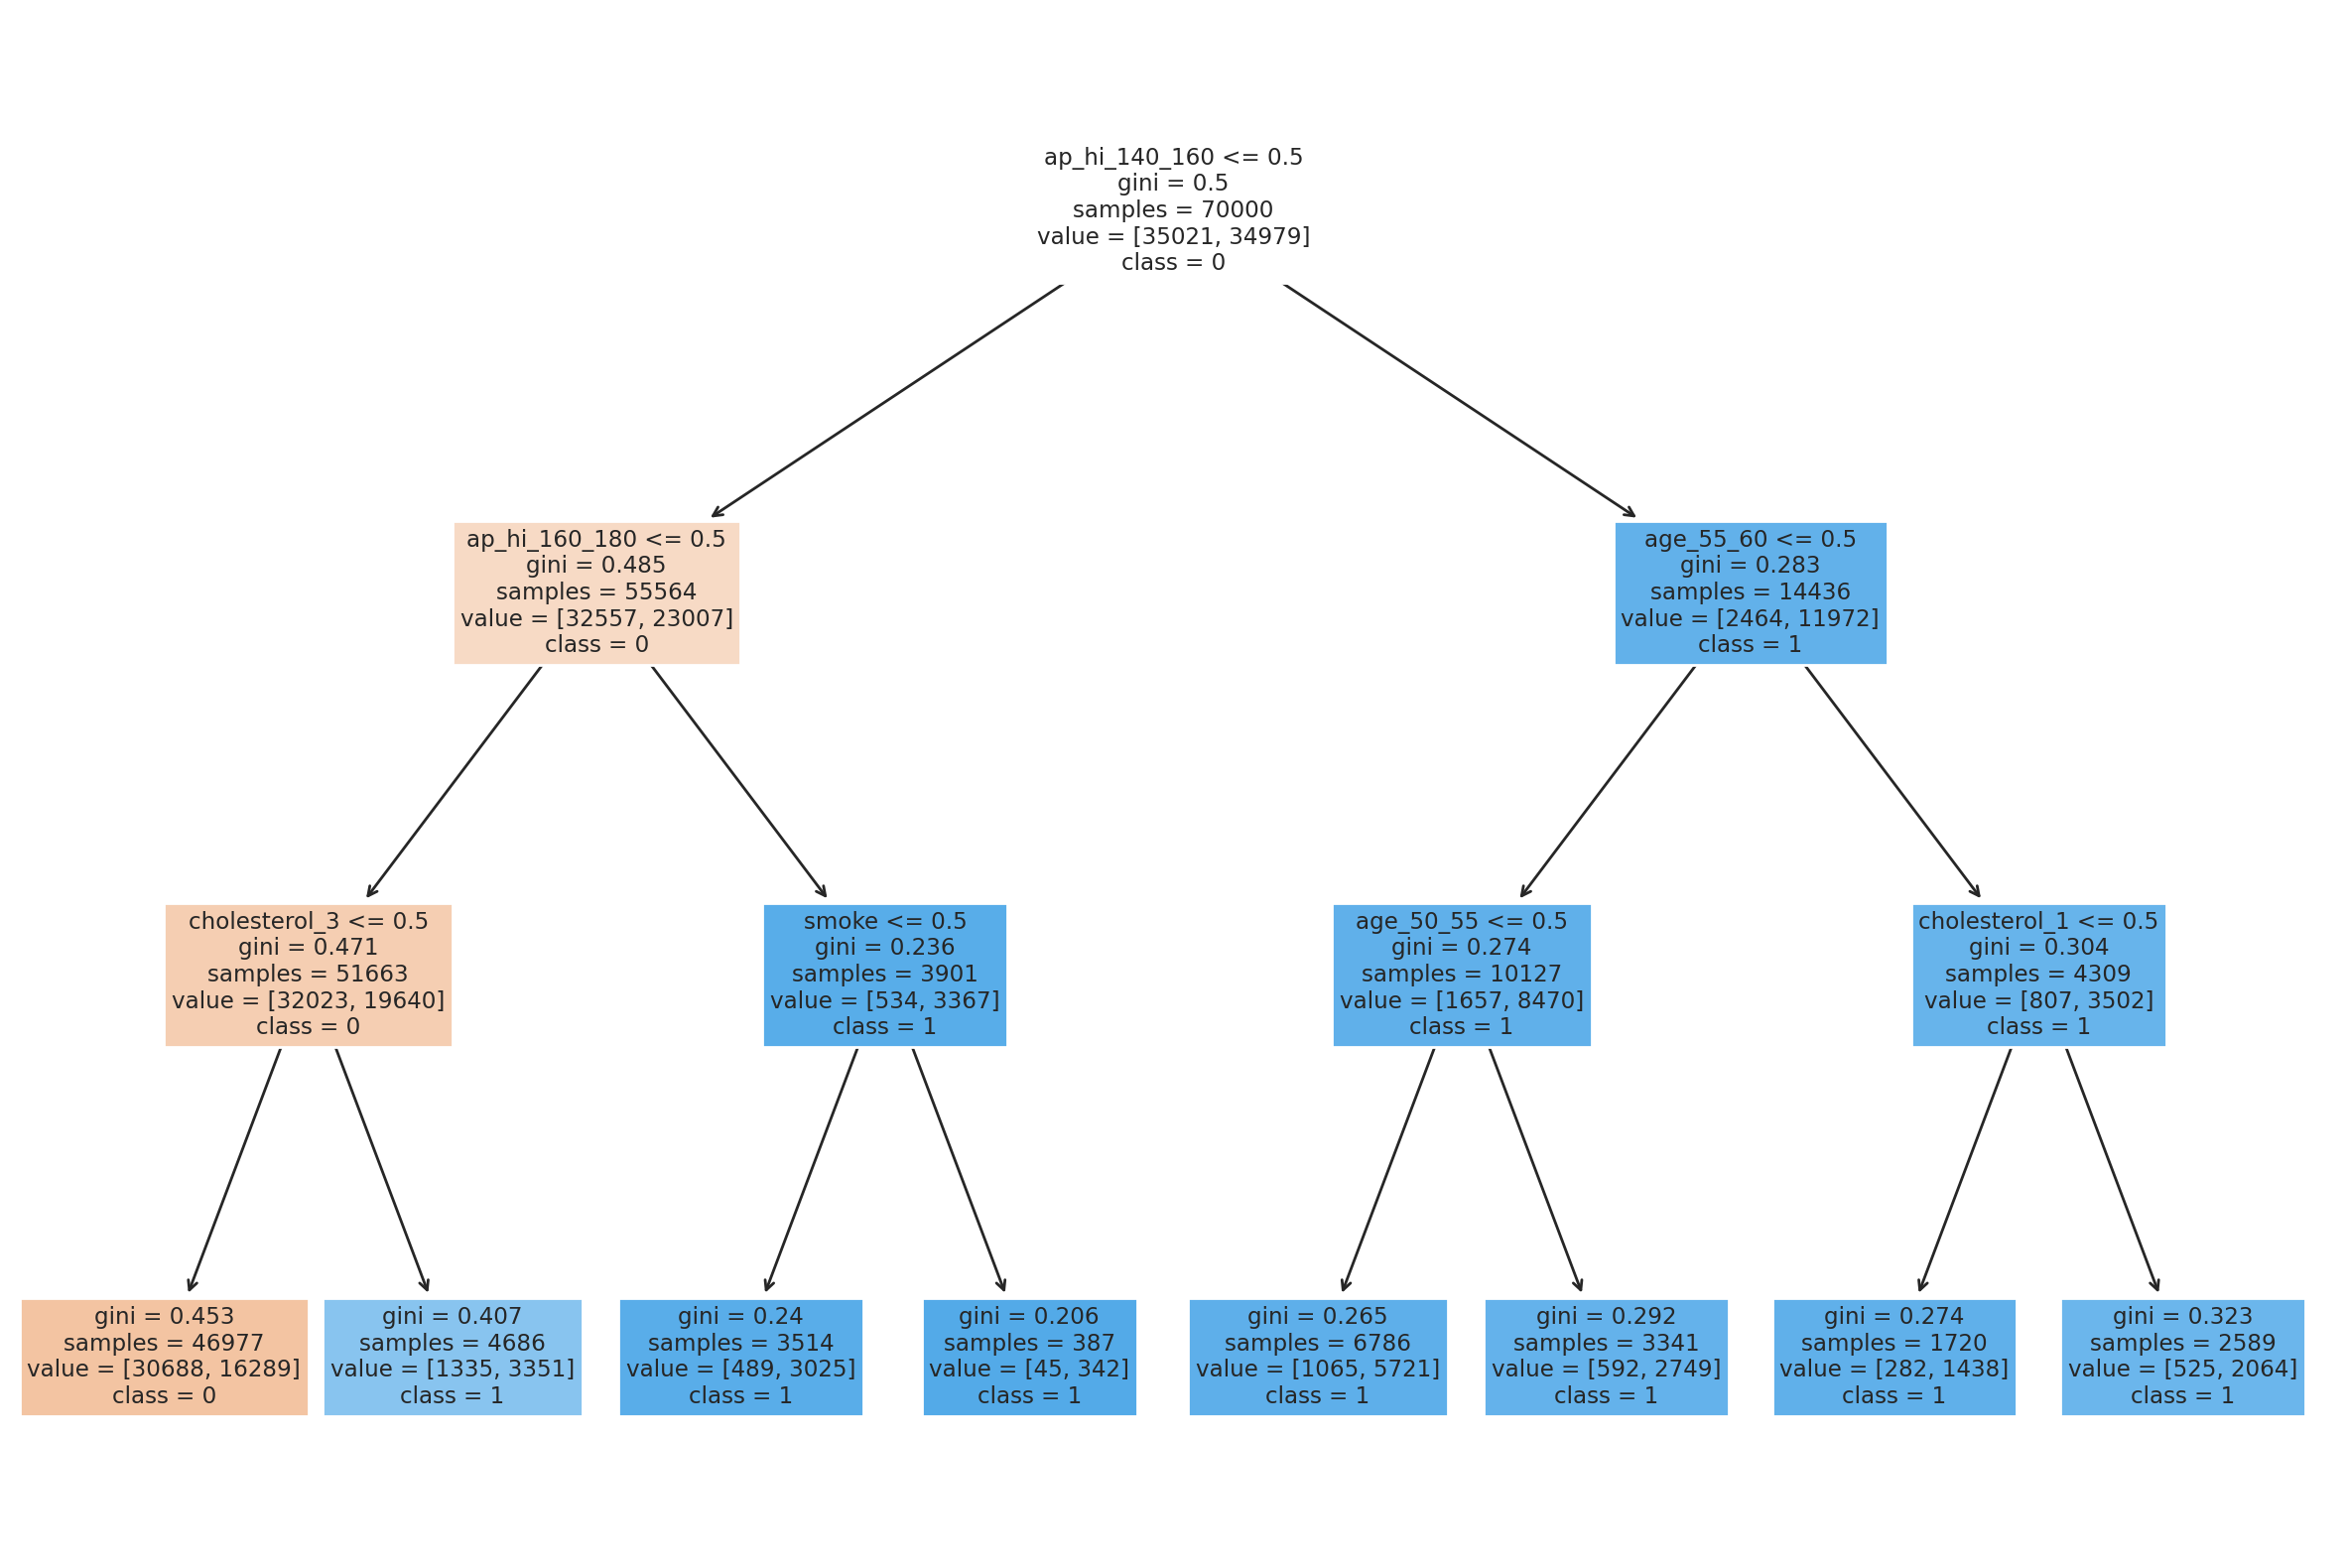

In [167]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(model_selected, 
                   feature_names=feature_names_selected,  
                   class_names=labels,
                   filled=True)